In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

import h5py
from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
#from models import *
#from utils.denoising_utils import *

# from facebook MRI
#import transforms
import pathlib
from common import args
import multiprocessing
import time

from models.cs.run_bart_val import save_outputs
#import sys
#sys.path.append('/root/signal_recovery_decoder/fastMRI')
from common import subsample
from data import transforms, mri_data
from common.utils import tensor_to_complex_np
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '2'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


# Data Loader

In [5]:
import pathlib
import random
import h5py
from torch.utils.data import Dataset

In [6]:
def savefig(filename,img):
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.savefig(filename,bbox_inches='tight')

In [7]:
 def crop_center(img,cropx,cropy):
    #y,x = img.shape
    y = img.shape[-2]
    x = img.shape[-1]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    if len(img.shape) == 2:
        img_crop=img[starty:starty+cropy,startx:startx+cropx]
        return img_crop
    if len(img.shape) == 3:
        img_crop=img[0,starty:starty+cropy,startx:startx+cropx]
        return img_crop


In [8]:
def get_mri_imgs(path = './fmri_datasets/singlecoil_val/'):
    data = []
    imgnames = [f for f in listdir(path) if isfile(join(path, f))]
    for imgname in imgnames:
        filename = path + imgname#'./fastMRI-master/singlecoil_val/file1001077.h5'
        f = h5py.File(filename, 'r')

        #nu = int(f['kspace'].shape[0] / 2) # get a middle slice so there is content
        nu = int(f['kspace'].shape[0] / 2) # get a middle slice so there is content
        ksp = f['kspace'][nu]  # get full kspace measurement
        
        #print('full kspace shape:', ksp.shape)

        ksp = crop_center(ksp,320,640)
       # print(ksp.shape) #shape (640,320)
        
        # l2 reconstruction from full kspace measurement
        img_l2 = sp.ifft(ksp)
        rang = np.max(np.abs(img_l2)) #- np.min(np.abs(img_l2))
        img_l2 /= rang
        ksp /= rang
        data += [(ksp, np.real(img_l2),filename)]
        #print(np.average(np.imag(img_l2)-np.real(img_l2)))
        #print(np.real(img_l2))
    print("collected ", len(data), " images")
    return data

In [9]:
data = get_mri_imgs()

collected  199  images


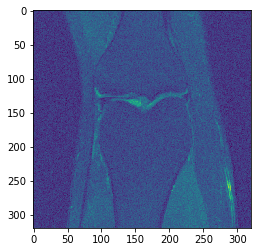

In [10]:
ksp_np,img_ref,filename = data[60]
plt.imshow(crop_center(img_ref,320,320))

# undersample and mask

In [11]:
img_var = np_to_var( np.array([img_ref]))
print(img_var.shape)
print(img_ref.shape)

torch.Size([1, 1, 640, 320])
(640, 320)


In [12]:
#measurement = ksp_np_to_measurement(ksp_np)*mask

mask shape: torch.Size([1, 1, 640, 320, 2])


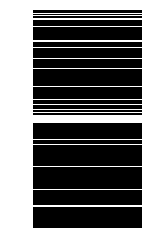

In [13]:
rng = np.random.RandomState()
center_fraction=0.04
num_cols=640
acceleration=8
num_low_freqs = int(round(num_cols * center_fraction))#center_fractions=[0.08, 0.04]
prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
mask2d = rng.uniform(size=num_cols) < prob
pad = (num_cols - num_low_freqs + 1) // 2
mask2d[pad:pad + num_low_freqs] = True
mask2d=mask2d[:,np.newaxis].repeat(320,axis=1)
mask2d=mask2d*1


wshape = img_ref.shape # (640,320)
mask = Variable( torch.zeros( (1,1,) + wshape + (2,) ) ).type(dtype)
mask[0,:,:,:,0] = np_to_var(mask2d)
mask[0,:,:,:,1] = np_to_var(mask2d)
print('mask shape:',mask.shape)

savefig('mask.png',mask2d)


In [14]:
def forwardm(img_var,mask=mask):
    fimg = Variable( torch.zeros(img_var.shape + (2,) ) ).type(dtype)
    fimg[:,:,:,:,0] = img_var #image data
    Fimg = transforms.fft2(fimg) #fourier transform to measurements
    return Fimg*mask #undersample measurements

# least squares reconstruction
def lsreconstruction(measurement):
    fimg = transforms.ifft2(measurement)
    return fimg[:,:,:,:,0]


#ksp: full kspace measurement to 2D fourier space representation
def ksp_np_to_measurement(ksp_np):
    Fimg = Variable( torch.zeros( (1,1,) + ksp_np.shape + (2,) ) ).type(dtype)
    Fimg[:,:,:,:,0] = np_to_var(np.real(ksp_np))
    Fimg[:,:,:,:,1] = np_to_var(np.imag(ksp_np))
    return Fimg

In [15]:
measurement = ksp_np_to_measurement(ksp_np)*mask
print(measurement.shape)
lsimg_var = lsreconstruction(measurement)

torch.Size([1, 1, 640, 320, 2])


# DD reconstruction

In [16]:
def dd_recovery(measurement,img_var,k=128):
    #measurement = forwardm(img_var).type(dtype)

    num_channels = [k]*6
    net = decodernw(1,num_channels_up=num_channels,upsample_first = False,bias=True).type(dtype)
    #net = decodernw(1,num_channels_up=num_channels,need_sigmoid=True).type(dtype)
   # net=fixed_deconv_decoder(1,num_channels_up=num_channels,filter_size=4,padding=1).type(dtype)
   # net = deconv_decoder(1,num_channels_up=num_channels,filter_size=4,stride=2,padding=1).type(dtype)
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=0.0,num_iter=15000,LR = 0.003,
                        img_noisy_var=measurement.type(dtype),
                        net=net,apply_f = forwardm,img_clean_var=img_var.type(dtype),
                        upsample_mode='bilinear',
                        )
    out_img_var = net( ni.type(dtype) )

    return out_img_var

In [17]:
torch.cuda.empty_cache()

In [18]:
out_img_var128 = dd_recovery(measurement,img_var)

input shape:  [1, 128, 10, 5]
optimize with adam 0.003


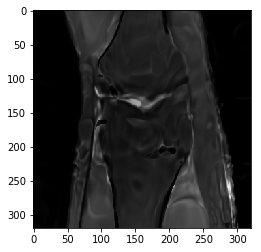

In [22]:
out_img_np128 = crop_center( out_img_var128.data.cpu().numpy()[0] ,320,320)

plt.imshow(out_img_np128,cmap='gray')

input shape:  [1, 256, 10, 5]
optimize with adam 0.003


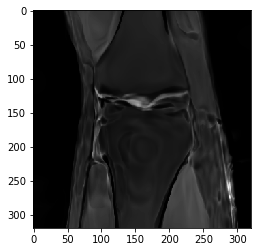

In [20]:
out_img_var256 = dd_recovery(measurement,img_var,256)
out_img_np256 = crop_center( out_img_var256.data.cpu().numpy()[0] ,320,320)
plt.imshow(out_img_np256,cmap='gray')

In [21]:
out_img_var512 = dd_recovery(measurement,img_var,512)
out_img_np512 = crop_center( out_img_var256.data.cpu().numpy()[0] ,320,320)
plt.imshow(out_img_np512,cmap='gray')

NameError: name 'measurements' is not defined

# L1 wavelet reconstruction

In [23]:
accel=4

In [24]:
print(ksp_np.shape,img_ref.shape)

(640, 320) (640, 320)


In [25]:
# least squares reconstruction
def lsreconstruction(measurement):
    fimg = transforms.ifft2(measurement)
    return fimg[:,:,:,:,0]
lsimg_var = lsreconstruction(measurement)

In [26]:
def get_l1wav(ksp_np,img_np,mask,from_ksp=False):
    if from_ksp:
        y = ksp_np
    else:
        
        mask2d=mask
        #print(mask2d.shape)
        #crop_center(img,cropx,cropy)
        #mask2d = mr.poisson( img_np.shape , accel=accel, calib=[24, 24]).astype(float)
        y = sp.fft(img_np)*mask2d
        print(sp.fft(img_np).shape)
    F = sp.linop.FFT(ksp_np.shape)
    P = sp.linop.Multiply(ksp_np.shape, mask2d)
    A = P * F

    lamda = 0.01 # best of 0.001, 0.01, 0.05, 0.005
    W = sp.linop.Wavelet(ksp_np.shape)
    proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)

    img_l1wav = sp.app.LinearLeastSquares(A, y, proxg=proxg).run()
    return img_l1wav.astype(float)

img_l1wav = get_l1wav(ksp_np,img_ref,mask2d)

(640, 320)


In [27]:
def get_TV(ksp_np,img_np,mask):
    mask2d=mask
    #mask2d = mr.poisson( img_np.shape , accel=accel, calib=[24, 24]).astype(float)
    y = sp.fft(img_np)*mask2d
    F = sp.linop.FFT(ksp_np.shape)
    P = sp.linop.Multiply(ksp_np.shape, mask2d)
    A = P * F

    lamda = 0.02 # best of: 0.001, 0.005, 0.01, 0.02, 0.05
    #W = sp.linop.Wavelet(ksp_np.shape)
    #proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)
    G = sp.linop.Gradient(img_np.shape)
    proxg = sp.prox.L1Reg(G.oshape, lamda)
    
    img_TV = sp.app.LinearLeastSquares(A, y, proxg=proxg,G=G).run()
    return img_TV.astype(float)

img_TV = get_TV(ksp_np,img_ref,mask2d)
print(img_TV.shape)


(640, 320)


# Get example reconstructions

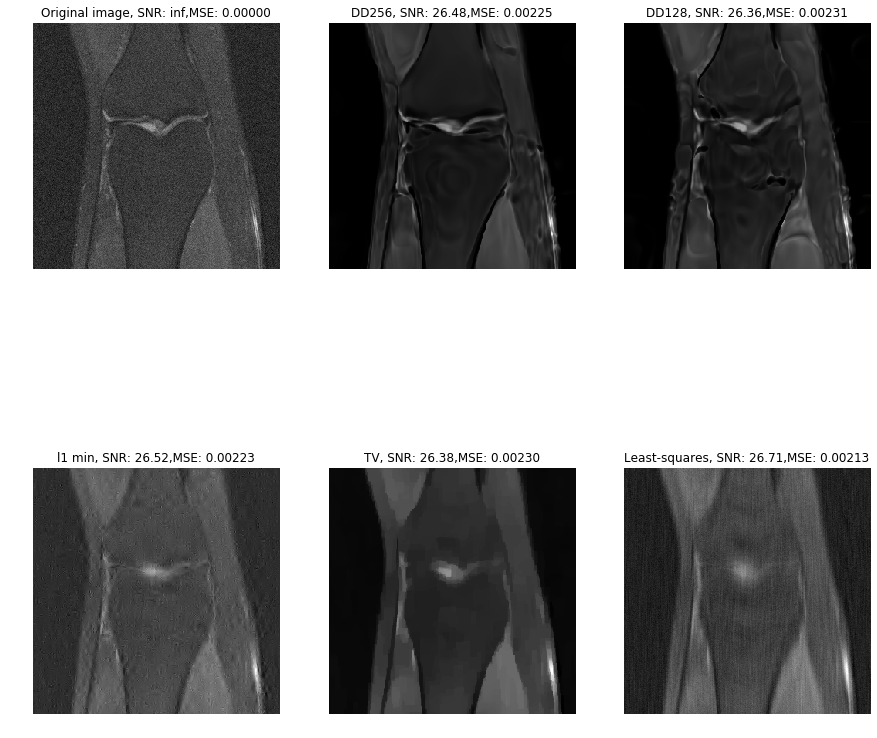

In [29]:
def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='gray')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))
    plt.axis('off')
       
def addimg(ax,name,img_np):
    ax.imshow(img_np,cmap='gray')
    ax.set_title( name + ", SNR: %.2f" % psnr(img_ref,img_np)+",MSE: %.5f"%
                 mse(img_ref,img_np))
                 #'\n'+ssim(img_ref,img_np,dynamic_range=img_ref.max()-img_ref.min())
               
    ax.axis('off')
    return ax

out_img_np128 = crop_center( out_img_var128.data.cpu().numpy()[0] ,320,320)
out_img_np256 = crop_center( out_img_var256.data.cpu().numpy()[0] ,320,320)
#out_img_np512 = crop_center( out_img_var512.data.cpu().numpy()[0] ,320,320)
img_ls_np = crop_center( lsimg_var.data.cpu().numpy()[0] ,320,320)
img_ref = crop_center(img_ref ,320,320)
img_l1wav = crop_center(img_l1wav ,320,320)
img_TV = crop_center(img_TV ,320,320)
    
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure

ax1 = fig.add_subplot(231)
ax1 = addimg(ax1,'Original image',img_ref)

ax2 = fig.add_subplot(236)
ax2 = addimg(ax2,'Least-squares',img_ls_np)

ax3 = fig.add_subplot(234)
ax3 = addimg(ax3,'l1 min',img_l1wav)

ax4 = fig.add_subplot(235)
ax4 = addimg(ax4,'TV',img_TV)

ax5 = fig.add_subplot(233)
ax5 = addimg(ax5,'DD128',out_img_np128)

ax6 = fig.add_subplot(232)
ax6 = addimg(ax6,'DD256',out_img_np256)

#ax7 = fig.add_subplot(512)
#ax7 = addimg(ax6,'DD256',out_img_np512)

plt.show()


NameError: name 'out_img_np256' is not defined

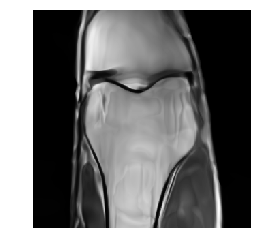

In [27]:
savefig('cartesian_mri_dd128' + str(accel) + '.png',out_img_np128)
#savefig('cartesian_mri_dd256' + str(accel) + '.png',out_img_np256)

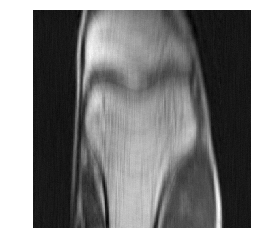

In [28]:
savefig('cartesian_mri_l1' + '.png',img_l1wav)
savefig('cartesian_mri_tv' + '.png',img_TV)
savefig('cartesian_mri_ls' + '.png',img_ls_np)

In [30]:
mse(img_ref,out_img_np128)

0.001818523233499807

In [31]:
mse(img_ref,img_l1wav)

0.0028296008155035794